In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D Plotting of Systems
import pandas as pd
from sympy import diff
from scipy import integrate
import scipy as sp
%matplotlib inline

In [2]:
def f_int(t, x, z):
    a, b, c, d, e, f = np.polyfit(x, z, 5)
    return(-t**2 * (5*a*t**4 + 4*b*t**3 + 3*c*t**2 + 2*d*t + e))

In [3]:
def volume_calc(x, z):
    mi = min(x)
    ma = max(x)
    v, err = integrate.quad(f_int, mi, ma, args = (x, z))
    return np.pi*v
    

In [4]:
#Runge-Kutta Method Single Time Step
def rk4(func, t, a, b, c, dt, b_k):
    """
    Peforms a single time step of the Runge-Kutta 4th Order Method.
    The below function finds the ki value for [dx,dy,dz] and return the value to move Yn+1
    func is an input of functions, for the Lorenz system this is [dx,dy,dz]
     
    Recall Rk4 Equations :
    k1 = h*f(xn,yn)
    k2 = h*f(xn+h/2,yn+k1/2)
    k3 = h*f(xn+h/2,yn+k2/2) 
    k4 = h*f(xn,yn+k3)
    Where f is a function [dx,dy,dz]
    Yn+1 = Yn + 1/6*(k1+k2+k3+k4)
    """
    
    k1, k2, k3, k4 = [], [], [], []
    
    for f in func:
        k1.append(dt*f(t, a, b, c, b_k))
        
    for f in func:
        k2.append(dt*f(t+dt/2, a+k1[0]/2, b+k1[1]/2, c+k1[2]/2, b_k))
        
    for f in func:
        k3.append(dt*f(t+dt/2, a+k2[0]/2, b+k2[1]/2, c+k2[2]/2, b_k))
        
    for f in func:
        k4.append( dt*f(t+dt, a+k3[0], b+k3[1], c+k3[1], b_k))
        
    k1, k2, k3, k4 = np.array(k1), np.array(k2), np.array(k3), np.array(k4)
    
    return (1/6)*(k1+2*k2+2*k3+k4)

In [5]:
#function, which calculate error for each c value and finds optipal value

In [6]:
# Constants 

# c = 10*1000/0.073


#b - radios od curvation 
#c - capillar const

#dx, df, dx for equtions, which determine form of the drop
def dx(t, x, fi, z, b):
    return np.cos(fi)

def dfi(t, x, fi, z, b):
    return 2*b-z-np.sin(fi)/(x+1e-5)

def dz(t, x, fi, z, b):
    return -np.sin(fi)

In [7]:
def Laplas(x0, fi0, z0, start_time, time_step, b, t_max):

    x, fi, z = [x0], [fi0], [z0] # Start Points
    count = 0
#     t = start_time or 0 # Start Time
#     dt = time_step or 0.01 # Time Step
    t = start_time  # Start Time
    dt = time_step  # Time Step
    
    while t < t_max:
        t+= dt
        tempx, tempfi, tempz = x[count], fi[count], z[count] # Temporary Start Points
        func = np.array([dx, dfi, dz])
        
        runge_kutta_4 = rk4(func, t, tempx, tempfi, tempz, dt, b) # Rk4 Function
        
        tempx += runge_kutta_4[0]
        tempfi += runge_kutta_4[1]
        tempz += runge_kutta_4[2]
        count +=1
        
        x.append(tempx)
        fi.append(tempfi)
        z.append(tempz)  
    return x, fi, z

In [8]:
#adress to Laplas function and then finds the polyfit approximation of the curve 
def graf(b, t_max):


    np.seterr(all='warn')
    x, fi, z = Laplas(0, 0, 0, 0, 0.01, b, t_max)

    t = np.linspace(0, 1.6, len(z))

    a, b, c, d, e, f = np.polyfit(x, z, 5)

    xx = np.arange(min(x), max(x), 0.01)
    yy = a*xx**5 + b*xx**4 + c*xx**3 + d*xx**2 + e*xx + f

#     plt.plot(xx, yy)
#     print(V)
    return (x, fi, z)



In [9]:
#finds current angle with diff
def angle(x, y):
    return np.arctan(np.diff(y)/np.diff(x))

In [10]:
#determine contact angle
def angl_exp(x1, y1):
    ln = len(x1)
    atan = np.arctan(diff(y1.loc[ln-10:ln-1])/diff(x1.loc[ln-10:ln-1])).dropna().reset_index(drop=True)
    return np.mean(atan), x1.loc[ln-1]/y1.loc[ln-1]

In [11]:
#finds x, z, which angle is equal to experimental
def finds_angle(agl, experim_angl):
    
    for i in range(1, len(agl)):
        if abs(agl[i])>abs(experim_angl):
            return i

In [12]:
#returns the index of the last element, before the shape becomes spiral
def find_cut_ind(agl):
    dif_agl = np.diff(agl)
    dt = list(filter(lambda x: x>0, dif_agl))
    plt.plot(dif_agl)
    a = (list(dif_agl).index(dt[0]))
    return a

In [13]:
#finds approximate value of b, using coefficient table 
def finds_b_approx(ct_angl, rat, coef_tbl, acur_rel, acur_rel_xz):
    
    df_agl = pd.DataFrame()
    acur_abs = ct_angl*acur_rel
    
    for j in range(len(coef_tbl)):
        if abs(coef_tbl['angle'].loc[j])<abs(ct_angl+acur_abs) and abs(coef_tbl['angle'].loc[j])>abs(ct_angl-acur_abs):
            df_agl = df_agl.append(coef_tbl.loc[j], ignore_index = True)

    acur_abs_xz = (acur_rel_xz*rat)
    df_fin = pd.DataFrame()
    
    for j in range(len(df_agl)):
        if abs(df_agl['x/z'].loc[j])<abs(rat+acur_abs_xz) and abs(df_agl['x/z'].loc[j])>abs(rat-acur_abs_xz):
            df_fin = df_fin.append(df_agl.loc[j], ignore_index = True)
    return df_fin

In [14]:
#function which normalize experimental data 
def normalize(x1, y1, z_ap):
    x2 = z_ap[len(z_ap)-1]*x1/y1.loc[len(y1)-1]
    y2 = z_ap[len(z_ap)-1]*y1/y1.loc[len(y1)-1]
    return x2, y2

In [15]:
#finds distance between exp and theor curves
def distance(b_i, T, x2, y2):
    x_ap, fi, z_ap = graf(b_i, T)
    
   
    
    x_ap_new =[]
    z_ap_new = []
    
    for j in range(len(x2)):
        df_c = []
        for i in range(len(x_ap)):
            df_c.append(abs(x2[j]-x_ap[i]))
        ind = df_c.index(min(df_c))
        x_ap_new.append(x_ap[ind])
        z_ap_new.append(z_ap[ind])    

    dist = []

    for n in range(len(x2)):
        x2_i = x2[n]
        y2_i = y2[n]
        x_ap_i = x_ap_new[n]
        z_ap_i = z_ap_new[n]
        dist_i = ((x_ap_i - x2_i)**2 + (z_ap_i - y2_i)**2)
        dist.append(dist_i)

    dist_v = sum(dist)/len(dist)
    
    return dist_v

In [16]:
def surf_ten(z_pr, y1):
    H_th = max(z_pr) - min(z_pr)
    H_exp = 0.000788
    c = (H_th/H_exp)**2
    return 10**4/c

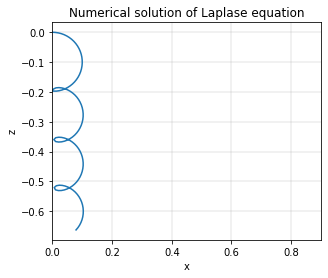

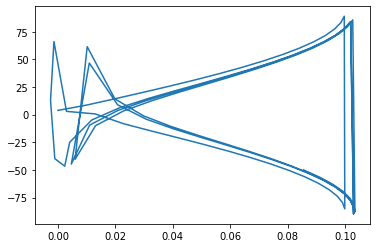

In [17]:
#main function, which adress to other functions and receive the x, z and fi

b = 10
t_max = 1.2
x, fi, z = graf(b, t_max)


agl = angle(x, z)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, z)

plt.title("Numerical solution of Laplase equation")
plt.xlabel("x")
plt.ylabel("z")
plt.grid(linewidth = 0.35)
ax.set_aspect('equal', adjustable='box')

plt.xlim(-0.9, 0)
plt.xlim(0, 0.9)
plt.figure()
plt.plot(x[0:-1], -agl*180/np.pi)


In [18]:
# start

     Unnamed: 0    x  y
0             0 -181 -8
1             1 -180 -9
2             2 -179 -9
3             3 -178 -9
4             4 -177 -9
..          ...  ... ..
861         861 -186 -8
862         862 -185 -8
863         863 -184 -8
864         864 -183 -8
865         865 -182 -8

[866 rows x 3 columns]
85.0
-1.448


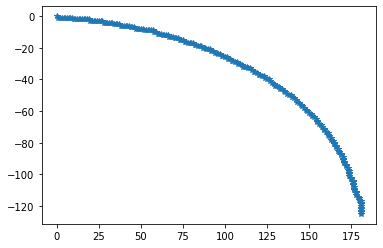

In [74]:
#Import exp data from file, plot graf and determine contact angle

Val_int = 200
Val = str(Val_int)
Mat = "Glyc"
Add = "None"
Per = "0"
Att = "2"


Tem_int = 26
Tem = str(Tem_int)

name = Val+ "_" + Mat + "_" + Add + "_" +Per + "_" + Att + "_" + Tem



# h = pd.read_csv(name + '.csv')

h = pd.read_csv('100_glic_alc_0_1_23.csv')

h['x'] = -h['x']
h['y'] = -h['y']

print(h)

# h['x'] = h['x'] - h['x'].loc[28]
# h['y'] = h['y'] - h['y'].loc[28]

# x1 = h['x'].loc[28:37].reset_index(drop=True)
# y1 = h['y'].loc[28:37].reset_index(drop=True)

mn = min(h['y'])
df2 = h[h['y']>mn].reset_index(drop=True)

ln = len(df2)

cut_num = ln//2-20

x1 = df2['x'].loc[0:cut_num].reset_index(drop=True) - df2['x'].loc[0]
y1 = df2['y'].loc[0:cut_num].reset_index(drop=True) - df2['y'].loc[0]


# plt.plot(x1, y1, marker = '*')

ct_angl, rat = angl_exp(x1, y1)
print(-ct_angl*180/np.pi)
print(rat)
# plt.plot(x, z)

plt.plot(x1, y1, linewidth = 0, marker = "*")


In [75]:
#import coefficient table and adress to function, which finds b


coef_tbl = pd.read_csv('coef.csv')
acur_rel = 0.01
acur_rel_xz = 0.005
df_approx = finds_b_approx(ct_angl, rat, coef_tbl, acur_rel, acur_rel_xz)

print(df_approx)


   T_max  Unnamed: 0     angle    b       x/z
0   1.95      1695.0 -1.480644  0.5 -1.441988


In [78]:
#finds optimized value of b

print(df_approx)
B_ap = float(df_approx['b'].loc[0])
T_ap = float(df_approx['T_max'].loc[0])
x_ap, f_ap, z_ap = graf(B_ap, T_ap)


x2, y2 = normalize(x1, y1, z_ap)
dist_v = distance(B_ap, T_ap, x2, y2)

x2_inter = np.linspace(min(x2), max(x2), len(x_ap))
y2_inter = np.interp(x2_inter, x2, y2)

step = 0.001
dev = 0.1
B_arr = np.arange(B_ap-dev, B_ap+dev, step)

dist_res = pd.DataFrame()

for b_i in B_arr:
    dist_v_i = distance(b_i, T_ap, x2, y2)
    dist_res_i = pd.DataFrame()
    dist_res_i['dist'] = [dist_v_i]
    dist_res_i['b'] = [b_i]
    dist_res = dist_res.append(dist_res_i)

min_dist = dist_res[dist_res['dist'] == min(dist_res['dist'])]
print(min_dist)
B_pr = min_dist['b'].loc[0]


   T_max  Unnamed: 0     angle    b       x/z
0   1.95      1695.0 -1.480644  0.5 -1.441988
       dist      b
0  0.000477  0.503


-1.4311500316864314
4.070970507534091


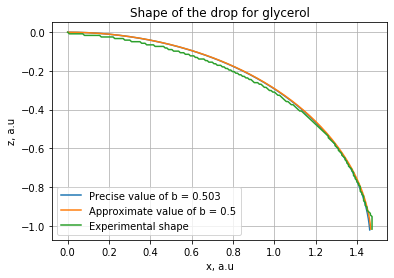

In [80]:
#plotting exp and theor curves

x_pr, f_pr, z_pr = graf(B_pr, T_ap)

V = volume_calc(x_pr, z_pr)

plt.plot(x_pr, z_pr, label = "Precise value of b = 0.503")

plt.plot(x_ap, z_ap, label = "Approximate value of b = 0.5")
plt.plot(x2, y2, label = "Experimental shape")
plt.grid(linewidth = 0.75)



plt.legend()
plt.xlabel('x, a.u')
plt.ylabel('z, a.u')
plt.title('Shape of the drop for glycerol')
print(x_pr[len(x_pr)-1]/z_pr[len(z_pr)-1])

print(V)

In [634]:
#constants
po = 1260
c = (Val_int*1e-9/V)**(-2/3)

In [635]:
df_output = pd.DataFrame()
df_output["Main_Material"] = [Mat]
df_output["Main_Value"] =[Val]
df_output["Addition_Material"] = [Add]
df_output["Percent_of_Addition_Material"] =[ Per]
df_output["Attempt"] = [Att]
df_output["Temperature"] = [Tem_int]
df_output["x/z"] = [rat]
df_output["angle"] = [ct_angl]
df_output["b"] =[ B_pr]
df_output["Value"] = [V]
df_output["cap_const"] = [c]
df_output["sigma"] = [9.81*po/c]

In [636]:
name_2 = name + "_" + "output"


df_output.to_csv(name_2 + ".csv")

In [615]:
# stop

55.61711597318982
54.99999999999999
-2.0157998396567596


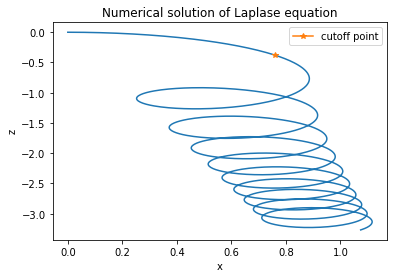

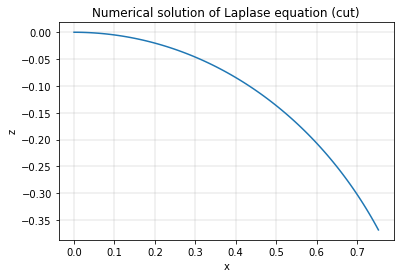

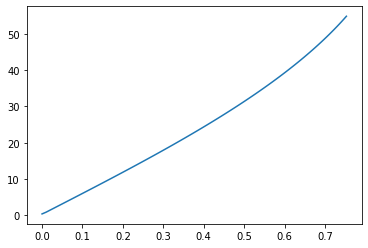

In [423]:
#plotting curve with point, denote the contact angle and cut curve 


ind = finds_angle(agl, ct_angl)



print(-agl[ind]*180/np.pi)
print(-ct_angl*180/np.pi)

plt.figure()
plt.plot(x, z)
plt.plot(x[ind], z[ind], marker = '*', label = "cutoff point")

plt.title("Numerical solution of Laplase equation")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()

x_cut = x[0:ind]
z_cut = z[0:ind]
agl_cut = agl[0:ind]

plt.figure()
plt.plot(x_cut, z_cut)
plt.title("Numerical solution of Laplase equation (cut)")
plt.xlabel("x")
plt.ylabel("z")
plt.grid(linewidth = 0.35)

plt.figure()
plt.plot(x_cut, -agl_cut*180/np.pi)

print(x[ind]/z[ind])

In [424]:
print(ct_angl)

-0.9599310885968811
